In [ ]:
# hide
#default_exp optimize
from nbdev import *

# Sampling optimizer

> The post-processing procedure to optimize the sampling of the distribution and re-fitting the sampling to a new temperature or draw new sampling from the set generated using `hecss.planner.plan_T_scan`.

In [ ]:
# export
import numpy as np
from numpy import log, exp, sqrt, linspace, dot
from scipy import stats
from scipy.special import expit
from matplotlib import pylab as plt
import ase
import ase.units as un
from ase.build import bulk
from spglib import find_primitive, get_symmetry_dataset
import spglib
import asap3
from tqdm.auto import tqdm
from hecss.core import select_asap_model
from hecss.monitor import plot_stats
from hecss.planner import plan_T_scan
from hecss.core import HECSS_Sampler

## Simulate with `stats.uniform` random variable

In [ ]:
rv = stats.uniform

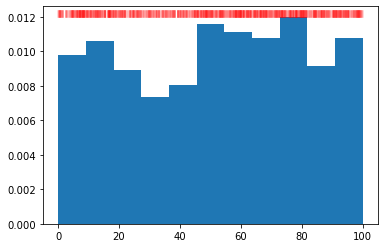

In [ ]:
N = 1_000
d = np.sort(rv.rvs(0, 100, size=N))
plt.hist(d, bins='auto', density=True);
skip = len(d)//2000
skip = int(max(1, skip))
for s in d[::skip]:
    plt.axvline(s, ymin=0.95, ymax=0.98, ls='-', color='r', alpha=0.2)

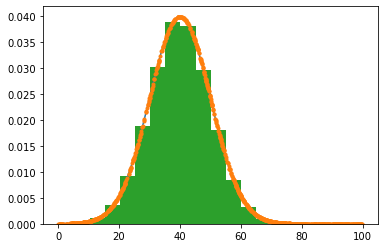

In [ ]:
# hide 
# Proof of concept - floating point waighted data
m = 40
s = 10
g = stats.norm(m, s)
x = np.linspace(0, 100, 300)
plt.plot(x, g.pdf(x), '-');
plt.plot(d, g.pdf(d), '.');
bw = d[2:]-d[:-2]
bp = (d[2:]+d[:-2])/2
# plt.plot(bp, g.pdf(bp), 'x')
Nb = min(20, len(d)//4)
plt.hist(d[1:-1], weights=g.pdf(bp)*bw, bins=Nb, density=True);

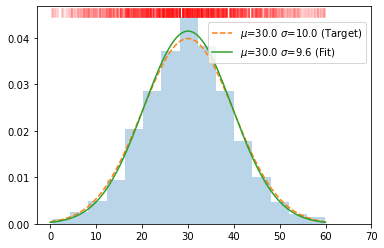

In [ ]:
def refit(data, mu, sigma, sigma_scale=0.9, N=None, Nb=None):
    if N is None:
        N = 10*len(data)
    # Use slightly (10%) wider sigma to compensate 
    # for the missing tails below weight=1
    g = stats.norm(mu, sigma_scale*sigma)
    d = np.sort(data)
    bw = d[2:]-d[:-2]
    bp = (d[2:]+d[:-2])/2
    w = g.pdf(bp)*bw
    w /= w.sum()
    nf = N
    # k = 0
    # while np.round(w*nf).sum() != N:
    #     nf += (N - np.round(w*nf).sum())/(np.round(w*nf).sum())
    #     # print(nf)
    #     if k > 50000:
    #         print(f'After {k=} iterations N={np.round(w*nf).sum():.0f}, giving up.')
    #         break
    #     k += 1
    # print(f'{k=}, {nf=}')
    # Block zero weights in the +/- 3*sigma zone to not lose data
    w = np.round(w*nf) + (1*(np.abs(d[1:-1] - mu) < 3*sigma))
    wd = list(flatten([int(ww)*[dd] for ww, dd in zip(w,d[1:-1]) if ww>=1]))
    # assert len(wd) == N
    if Nb is None :
        Nb = min(len(data)//4, 15)
    h, b, _ = plt.hist(wd, bins=Nb, density=True, alpha=0.3);
    x = np.linspace(mu-3*sigma, mu+3*sigma, 300)
    fit = stats.norm.fit(wd)
    plt.plot( x, stats.norm.pdf(x, mu, sigma), '--', label=f'$\mu$={mu:.1f} $\sigma$={sigma:.1f} (Target)' )
    plt.plot( x, stats.norm.pdf(x, *fit), label=f'$\mu$={fit[0]:.1f} $\sigma$={fit[1]:.1f} (Fit)' )
    skip = len(d)//2000
    skip = int(max(1, skip))
    nf = (w[::skip]).max()
    for s, a in zip(d[1:-1:skip], w[::skip]):
        if a<1e-3:
            continue
        plt.axvline(s, ymin=0.95, ymax=0.99, ls='-', color='r', alpha=np.sqrt(a/nf))
    
    return w, wd
              
m = 30
s = 10
w, wd = refit(d, m, s)
plt.xlim(None, m+4*s)
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95));

In [ ]:
w[w>0].sum(), len(wd), len(w[w>0])

(1047.0, 1047, 50)

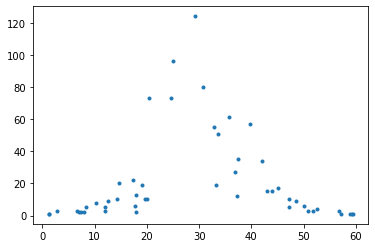

In [ ]:
plt.plot(d[1:-1][w>0], w[w>0], '.')

In [ ]:
#export
def HECSS_Sampler_TNG(cryst, calc, T_goal, width=1, maxburn=20, 
            N=None, w_search=True, delta_sample=0.01, sigma=2,
            eqdelta=0.05, eqsigma=0.2,
            xi=1, chi=1, xscale_init=None,
            logistic_dist = True,
            Ep0=None, modify=None, modify_args=None, symprec=1e-5,
            directory=None, reuse_base=None, verb=True, pbar=False,
            width_list=None, dofmu_list=None, xscale_list=None):
    '''
    Run HECS sampler on the system `cryst` using calculator `calc` at target
    temperature `T_goal`. The `delta`, `width`, `maxburn` and `directory` 
    parameters determine detailed aspects of the algorithm.

    This is a generator and cannot be used as regular function. 
    It is intended to be used as a source of the sequence of 
    configurations in the `for` loop and must be closed after 
    finishing the iteration. On the other hand, the iteration 
    may be continued if additional samples are required. 
    The state is preserved until the .close() method is called.
    
    INPUT
    -----
    cryst        : ASE structure to sample
    calc         : ASE calculator to use for potential energy evaluations
    T_goal       : Target temperature in Kelvin
    width        : initial width of the position distribution, relative 
                   to the heurestic value defined inside function                  
    maxburn      : max number of burn-in steps
    N            : Number of iterations. If None (default) the generator never stops.
    w_search     : Run search for initial w. If false start from whatever 
                   is passed as width.
    delta_sample : Prior width adaptation rate. The default is sufficient in most cases.
    sigma        : Range around E0 in sigmas to stop w-serach mode
    eqdelta      : Max. speed of amplitude correction from step to step (0.05=5%)
    eqsigma      : Half width of linear part of amplitude correction function.
    xi           : strength of the amplitude correction term [0-1]
    chi          : strength of the amplitude correction term mixing [0-1]
    xscale_init  : Initial values of the amplitude correction coefficients.
                   Array with shape `cryst.get_positions().shape`.
                   May be generated with `calc_init_xscale` function.
    Ep0          : T=0 energy (base, no dstortions), if None (default) calculate E0.
    modify       : pass your own pre-processing function to modify the structure 
                   before calculation. The function must return a  (e, f) tuple
                   with energy of the structure (e, scalar) and forces (f, array).
    modify_args  : dictionary of extra arguments to pass to modify function
    symprec      : symmetry detection treshold for spglib functions
    directory    : (only for VASP calculator) directory for calculations and generated samples. 
                   If left as None, the `calc/{T_goal:.1f}K/` will be used and the generated 
                   samples will be stored in the `smpl/{i:04d}` subdirectories.
    reuse_base   : None or the base calculator created by restarting the ground 
                   state config. If None the base will be recalculated at the start of the run.
                   If the value is a calculator - the energy from this calculator will be used 
                   as ground state energy for the calculation. Be careful to have the same setup 
                   in calc and reuse_base, otherwise the ground state energy and distribution 
                   will be wrong.
    verb         : print verbose progress messages for interactive use
    pbar         : tqdm progress bar object. If False (default) there will be no output.
                   If set to None the display will be printed to stdout.
    
    **Output parameters**
    
    width_list   : Output parameter. If not None, store in passed list the sequence of widths.
    dofmu_list   : Output parameter. If not None, store in passed list the array of DOF virials
                   relative to temperature (T_goal).
    xscale_list  : Output parameter. If not None, store in passed list the array of amplitude 
                   correction coefficients (normalized). May be used to generate `xscale_init`
                   values with the help of `calc_init_xscale` function.

    OUTPUT
    ------
    The generator yields samples from the thermodynamic distribution at T=T_goal as tuples
    (number, index, displacement, forces, energy):
    
    - number       : sample number, always increasing
    - index        : integer numbering the samples in the `smpl` subdirectory. 
                     Index repeats if the sample must be repeated in the sequence. 
    - displacement : set of atomic displacements (in A) in the sample (numpy array)
    - forces       : set of forces (in eV/A) generated by the displacement
    - energy       : potential energy of the configuration

    '''    
    
    if pbar:
        pbar.set_postfix(Sample='initial')
    
    def smpl_print():
        max_r = 15
        if pbar:
            if i==0:
                pbar.set_postfix(Sample='burn-in', n=k, w=w,
                                 dE=f'{(e_star-E_goal)/Es:+6.2f} sigma', 
                                 xs=f'{sqrt(xscale.std()):6.3f}')
            else :
                pbar.set_postfix(xs=f'{sqrt(xscale.std()):6.3f}', config=f'{i:04d}', 
                                 w=w, w_bar=f'{np.mean([_[0] for _ in wl]) if wl else w:7.3f}')
        elif pbar is None :
            if i==0:
                print(f'Burn-in sample {sqrt(xscale.std()):6.3f}:{k}'
                      f'  w:{w:.4f}'
                      f'  dE:{(e_star-E_goal)/Es:+6.2f} sigma', end='\n')
            else :
                print(f'Sample {sqrt(xscale.std()):6.3f}:{n:04d}'
                      f'w:{w:.4f}  <w>:{np.mean([_[0] for _ in wl]) if wl else w:.4f}', end='\n')
            sys.stdout.flush()
        else :
            pass

        
    def print_xs(c, s):
        elmap = c.get_atomic_numbers()
        for el in sorted(set(elmap)):
            print(f'{chemical_symbols[el]:2}: {s[elmap==el,:].mean():8.4f}', end='  ')
        print()
    
        
    nat = len(cryst)
    dim = (nat, 3)
    
    symm = get_symmetry_dataset(cryst, symprec=symprec)
    dofmap = symm['mapping_to_primitive']
    dof = list(sorted(set(dofmap)))
    dofmu = np.ones((len(dof), 3))
    mu = np.ones(dim)

    if xscale_init is None:
        xscale = np.ones(dim)
    else :
        xscale = np.array(xscale_init)
        assert xscale.shape == dim
    
    # Initialise dofxs from data passed in xscale_init
    dofxs = np.array([xscale[dofmap==d,:].mean(axis=0) for d in dof])
    assert dofxs.shape == dofmu.shape
            
    xi = max(0,xi)
    xi = min(1,xi)

    assert 0 <= xi <= 1 
    
    chi = max(0,chi)
    chi = min(1,chi)

    assert 0 <= chi <= 1 
    
    if Ep0 is None:
        if reuse_base is not None:
            calc0 = reuse_base
            Ep0 = calc0.get_potential_energy()
        else:
            Ep0 = cryst.get_potential_energy()
    
    E_goal = 3*T_goal*un.kB/2
    Es = np.sqrt(3/2)*un.kB*T_goal/np.sqrt(nat)   
    
    
    # This comes from the fitting to 3C-SiC case
    w_scale = 1.667e-3 * (T_goal**0.5) #(T_goal**0.47)
    
    w = width
    w_prev = w

    if width_list is None :
        wl = []
    else :
        wl = width_list

    if logistic_dist:
        Q = stats.logistic
        w_scale *= 0.5
        # adiust w scalling to the distro shape
    else:
        Q = stats.norm

    P = Q.pdf
    
    i = 0
    n = 0
    
    if directory is None :
        basedir = f'calc/T_{T_goal:.1f}K'
    else :
        basedir = directory

    cr = ase.Atoms(cryst.get_atomic_numbers(), 
                   cell=cryst.get_cell(),
                   scaled_positions=cryst.get_scaled_positions(),
                   pbc=True, calculator=calc)
    
    try :
        cr.calc.set(directory=f'{basedir}/smpl/{i:04d}')
    except AttributeError :
        # Calculator is not directory-based
        # Ignore the error
        pass

    # Start from the equilibrium position
    e = 0
    x = np.zeros(dim)
    f = np.zeros(dim)
    
    k = 0
    
    if pbar:
        pbar.set_postfix(Sample='burn-in')

    while True:

        # print_xs(cryst, xscale)
        #x_star =  Q.rvs(size=dim, scale=w * w_scale * xscale)
        x_star = xscale * Q.rvs(size=dim, scale=w * w_scale)

        assert x_star.shape == dim        

        if verb and (n>0 or k>0):
            smpl_print()
        
        cr.set_positions(cryst.get_positions()+x_star)
        try :
            cr.calc.set(directory=f'{basedir}/smpl/{i:04d}')
        except AttributeError :
            pass

        try :
            if modify is not None:
                e_star, f_star = modify(cr, cryst, 's', *modify_args)
            else:
                e_star = cr.get_potential_energy()
                f_star = cr.get_forces()
        except calculator.CalculatorError:
            print(f"Calculator in {cr.calc.directory} faild.\n", file=sys.stderr)
            print("Ignoring. Generating next displacement.", file=sys.stderr)
            continue

        e_star = (e_star-Ep0)/nat
        
        wl.append((w,e_star))

        if i==0 :
            # w-search mode
            delta = 10 * delta_sample
        else :
            # sampling mode
            delta = delta_sample

        w_prev = w

        # Equilibrate all degrees of freedom
        mu = np.abs(f_star*x_star)/(un.kB*T_goal)
        # mu = np.abs(f_star*x_star)/(np.abs(f_star*x_star).mean())
        
        # Avarage mu over images of the atom in the P.U.C.
        dofmu = np.array([mu[dofmap==d,:].mean(axis=0) for d in dof])

        # We use sqrt(mu) since the energy is quadratic in position
        # eqdelta = 0.05 => 5% maximum change in xscale from step to step
        # eqsigma = 0.2 => half width/sharpness of the sigmoid, 
        #                  roughly linear part of the curve
        dofxs *= (1-2*eqdelta*(expit((np.sqrt(dofmu)-1)/eqsigma)-0.5))
        
        # We need to normalize to unchanged energy ~ xs**2
        # The scale must be back linear in xs, thus sqrt(<xs>)
        dofxs /= np.sqrt((dofxs**2).mean())
        
        xscale = (chi * dofxs[dofmap] + xscale * (1 - chi))
        
        # mix with unity: (xi*xs + (1-xi)*1), 0 < xi < 1
        xscale = (xi*xscale + np.ones(dim) - xi) 

        if xscale_list is not None:
            xscale_list.append(np.array(xscale))

        if dofmu_list is not None:
            dofmu_list.append(np.array(dofmu))
            
        if w_search :
            w = w*(1-2*delta*(expit((e_star-E_goal)/Es/3)-0.5))
            if i==0 and abs(e_star-E_goal) > sigma*Es :
                # We are in w-search mode but still far from E_goal
                # Continue
                k += 1
                if k>maxburn :
                    print(f'\nError: reached maxburn ({maxburn}) without finding target energy.\n'+
                        f'You probably need to change initial width parameter (current:{w})' +
                        f' to a {"higher" if (e_star-E_goal)<0 else "lower"} value.')
                    return
                # Continue searching for proper w
                # print(f'{w=} ({abs(e_star-E_goal)/(sigma*Es)}). Continue searching')
                continue

        if i==0 :
            # We are in w-search mode and just found a proper w
            # switch to sampling mode by cleaning up after the initial samples
            # clean up the w table
            wl.clear()

        x = x_star
        e = e_star
        f = f_star
        i += 1
        n += 1
        
        smpl_print()
        if pbar:
            pbar.update()

        yield n, i-1, x, f, e
        
        if N is not None and n > N:
            break
    
    if pbar:
        pbar.close()

In [ ]:
# asap

from ase.build import bulk
from ase.spacegroup import crystal
import asap3
from hecss.monitor import plot_stats, plot_virial_stat, plot_xs_stat
from hecss.monitor import plot_acceptance_history, plot_dofmu_stat
from hecss.core import select_asap_model

# Local copy of model from OpenKIM-models from 2019
# model = 'data/Tersoff_LAMMPS_ErhartAlbe_2005_SiC__MO_903987585848_003'
# Model form 2019 OpenKIM-models package
# model = 'Tersoff_LAMMPS_ErhartAlbe_2005_SiC__MO_903987585848_003'
# Model form 2021 OpenKIM-models package
# model = 'Tersoff_LAMMPS_ErhartAlbe_2005_SiC__MO_903987585848_004'
# model = 'Tersoff_LAMMPS_ErhartAlbe_2005SiII_SiC__MO_408791041969_003'
# model = 'MEAM_LAMMPS_KangEunJun_2014_SiC__MO_477506997611_000'

model = select_asap_model('SiC')
print(f'Using potential model: {model}')

sys_size = '1x1x1'
sys_size = '2x2x2'
sys_size = '3x3x3'
sys_size = '4x4x4'
sys_size = '5x5x5'
sc = [int(v) for v in sys_size.split('x')]
cryst = bulk('SiC', crystalstructure='zincblende',
                 a=4.38120844, cubic=True).repeat(tuple(sc))
cryst.set_calculator(asap3.OpenKIMcalculator(model))

Using potential model: MEAM_LAMMPS_KangEunJun_2014_SiC__MO_477506997611_000


In [ ]:
from rich.progress import track

Output()

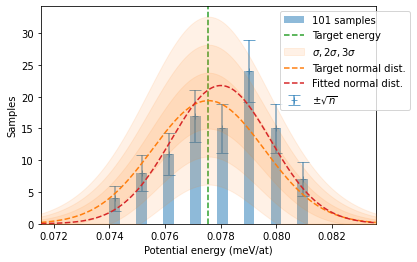

In [ ]:
T = 600
N = 100
sampler = HECSS_Sampler(cryst, asap3.OpenKIMcalculator(model), T_goal=T, N=N, pbar=False)
smpls = [s for s in track(sampler, "HECSS", total=N, transient=False)]
plot_stats(smpls, T, sqrN=True, show=False)
plt.savefig('hecss.pdf', bbox_inches='tight')

Output()

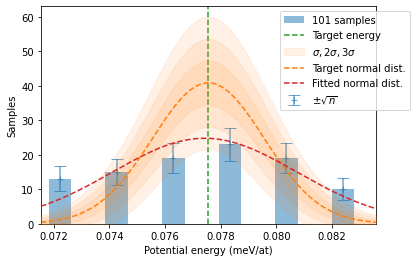

In [ ]:
T = 600
N = 100
sampler_ng = HECSS_Sampler_TNG(cryst, asap3.OpenKIMcalculator(model), T_goal=T, 
                        logistic_dist=True, N=N)
smpls_ng = [s for s in track(sampler_ng, "HECSS", total=N, transient=False)]
plot_stats(smpls_ng, T, sqrN=True, show=False)
plt.savefig('hecss_ng.pdf', bbox_inches='tight')

In [ ]:
# export
def make_sampling(data, T, sigma_scale=1.0, N=None, Nb=None, nonzero_w=False, debug=False):
    if N is None:
        N = 4*len(data)
    if Nb is None :
        Nb = min(len(data)//4, 15)
    # Use slightly (10%) wider sigma to compensate 
    # for the missing tails below weight=1
    nat = data[0][2].shape[0]
    mu = 3*T*un.kB/2
    sigma = np.sqrt(3/2)*un.kB*T/np.sqrt(nat)   

    g = stats.norm(mu, sigma_scale*sigma)
    e = np.fromiter((s[-1] for s in data), float)
    idx = np.argsort(e)
    ridx = np.arange(len(idx))[idx]
    d = e[idx]
    if debug:
        # print(idx.shape, d.shape, mu-sigma, 2*sigma)
        mh = plt.hist(d, bins=Nb, density=False)[0].max()
        
        plt.plot(d, 1.1*mh*np.ones(d.shape), '|', alpha=max(0.01, min(1.0, 100/len(d))))
        # plt.xlim(mu-3*sigma, mu+4*sigma)
        plt.title('Raw data')
        plt.show()
    # bw = d[2:]-d[:-2]
    # bp = (d[2:]+d[:-2])/2
    bw = np.zeros(d.shape)
    bp = np.zeros(d.shape)
    bp[:-1] = (d[1:] + d[:-1])/2
    bw[1:-1] = bp[1:-1] - bp[:-2]
    bw[0] = d[1]-d[0]
    bw[-1] = d[-1]-d[-2]
    bp[1:-1] = (bp[0:-2] + bp[1:-1])/2
    bp[0] = d[0]
    bp[-1] = d[-1]

    w = g.pdf(bp)*bw
    # w = stats.uniform.pdf(bp, mu-sigma, 2*sigma)*bw
    w /= w.sum()
    nf = N

    if debug:
        plt.plot(bp, w, '.')
        # plt.xlim(mu-3*sigma, mu+4*sigma)
        plt.plot(bp, 2*np.cumsum(w)/len(w), '.')
        x = linspace(e.min(), e.max(), 100)
        plt.plot(x, 2*g.cdf(x)/len(w), '-')
        plt.axhline(2/len(w), ls=':', color='k', lw=1)
        plt.title('Data weights')
        plt.show()
        plt.hist(d, weights=w, bins=Nb, density=True)
        plt.title('Weighted data (without nonzero_w)')
        # plt.xlim(mu-3*sigma, mu+4*sigma)
        plt.show()
    
    # Block zero weights in the +/- 3*sigma zone to not lose data
    w = np.round(w*nf) 
    if nonzero_w:
        w += (1*(np.abs(d - mu) < 3*sigma))
    
    # wdi = np.fromiter(flatten(int(ww)*[ii] for ww, ii in zip(w,ridx[1:-1]) if ww>=1), int)
    # wd = [data[i] for i in wdi]
    # wde = d[wdi]
    wd = []
    for ww, ii in zip(w,idx):
        if ww<1:
            continue
        wd += int(ww)*[data[ii]]
    # print(len(wd), wde.shape)
    # assert len(wd) == N
    if debug:
        wde = np.fromiter((s[-1] for s in wd), float)
        h, b, _ = plt.hist(wde, bins=Nb, density=True, alpha=0.3);
        # assert h.sum() == len(wde)
        x = np.linspace(mu-3*sigma, mu+3*sigma, 300)
        fit = stats.norm.fit(wde)
        plt.plot( x, stats.norm.pdf(x, mu, sigma), '--', 
                 label=f'$\mu$={2*mu/3/un.kB:.1f}; $\sigma$={2*sigma/3/un.kB:.1f} (Target)' )
        plt.plot( x, stats.norm.pdf(x, *fit), 
                 label=f'$\mu$={2*fit[0]/3/un.kB:.1f}; $\sigma$={2*fit[1]/3/un.kB:.1f} (Fit)' )
        plt.title('Generated weighted sample')
        skip = len(d)//2000
        skip = int(max(1, skip))
        print(skip)
        nf = (w[::skip]).max()
        for s, a in zip(d[::skip], w[::skip]):
            if a<1e-3:
                continue
            plt.axvline(s, ymin=0.95, ymax=0.99, ls='-', color='r', alpha=np.sqrt(a/nf))
        plt.xlim(mu-3*sigma, mu+4*sigma)
        plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95));
    return wd

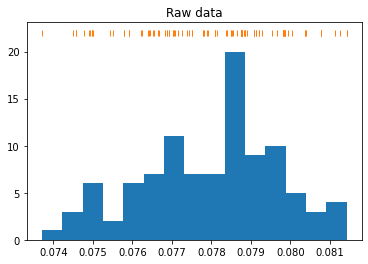

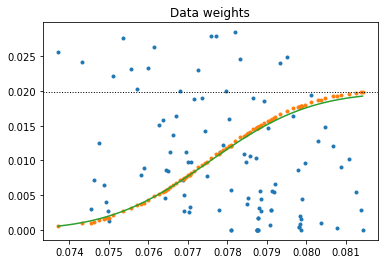

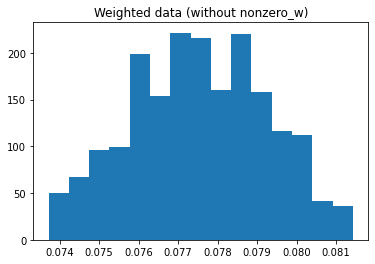

1


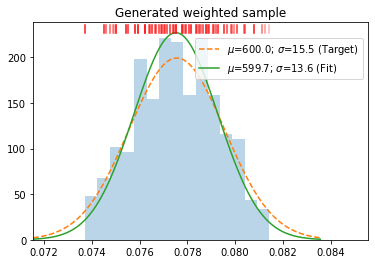

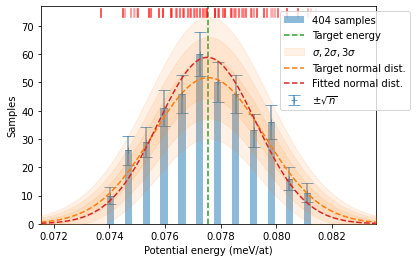

In [ ]:
wd = make_sampling(smpls, T, debug=True)
plt.show()
plot_stats(wd, T, sqrN=True, show=False)
skip = max(1, len(wd)//2000)
alpha = min(1,50*skip/len(wd))
for s in wd[::skip]:
    plt.axvline(s[-1], ymin=0.95, ymax=0.99, ls='-', color='r', alpha=alpha)
plt.savefig('hecss_opt.pdf', bbox_inches='tight')

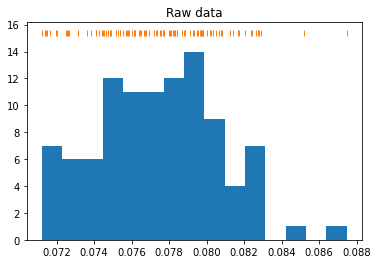

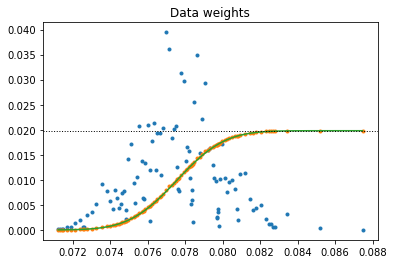

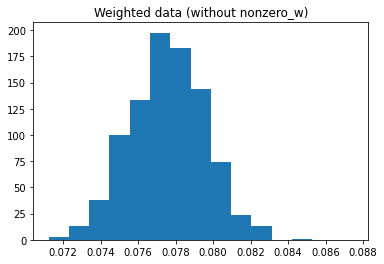

1


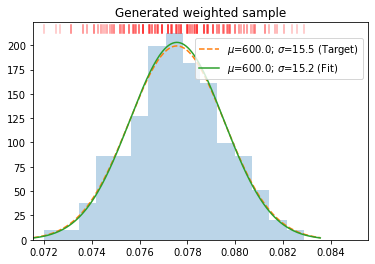

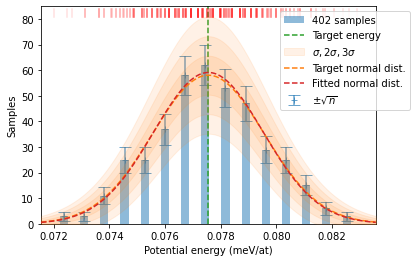

In [ ]:
wd = make_sampling(smpls_ng, T, debug=True)
plt.show()
plot_stats(wd, T, sqrN=True, show=False)
skip = max(1, len(wd)//2000)
alpha = min(1,50*skip/len(wd))
for s in wd[::skip]:
    plt.axvline(s[-1], ymin=0.95, ymax=0.99, ls='-', color='r', alpha=alpha)
plt.savefig('hecss_ng_opt.pdf', bbox_inches='tight')

In [ ]:
# export
def get_sample_weights(data, T, Nb=None, nonzero_w=False, debug=False):

    if Nb is None :
        Nb = min(len(data)//4, 15)
    
    nat = data[0][2].shape[0]
    mu = 3*T*un.kB/2
    sigma = np.sqrt(3/2)*un.kB*T/np.sqrt(nat)   

    g = stats.norm(mu, sigma)
    e = np.fromiter((s[-1] for s in data), float)
    idx = np.argsort(e)
    ridx = np.arange(len(idx))[idx]
    d = e[idx]
    if debug:
        # print(idx.shape, d.shape, mu-sigma, 2*sigma)
        mh = plt.hist(d, bins=Nb, density=False)[0].max()
        plt.plot(d, 1.1*mh*np.ones(d.shape), '|')
        # plt.xlim(mu-3*sigma, mu+4*sigma)
        plt.title('Raw data')
        plt.show()
    
    bw = np.zeros(d.shape)
    bp = np.zeros(d.shape)
    bp[:-1] = (d[1:] + d[:-1])/2
    bw[1:-1] = bp[1:-1] - bp[:-2]
    bw[0] = d[1]-d[0]
    bw[-1] = d[-1]-d[-2]
    bp[1:-1] = (bp[0:-2] + bp[1:-1])/2
    bp[0] = d[0]
    bp[-1] = d[-1]
    w = g.pdf(bp)*bw
    # w = stats.uniform.pdf(bp, mu-sigma, 2*sigma)*bw
    w /= w.sum()

    if debug:
        plt.plot(d, w, '.')
        # plt.plot(bp, w, '|')
        # plt.step(d, w, where='mid')
        plt.plot(bp, 2*np.cumsum(w)/len(w), '.')
        x = linspace(e.min(), e.max(), 100)
        plt.plot(x, 2*g.cdf(x)/len(w), '-')
        plt.axhline(2/len(w), ls=':', color='k', lw=1)
        # plt.xlim(mu-3*sigma, mu+4*sigma)
        plt.title('Data weights')
        plt.show()
        plt.hist(d, weights=w, bins=Nb, density=False)
        plt.title('Weighted data (without nonzero_w)')
        # plt.xlim(mu-3*sigma, mu+4*sigma)
        plt.show()
    
    # Block zero weights in the +/- 3*sigma zone to not lose data
    if nonzero_w:
        w += (nonzero_w*w.mean()*(np.abs(d[1:-1] - mu) < 3*sigma))
    
    # wdi = np.fromiter(flatten(int(ww)*[ii] for ww, ii in zip(w,ridx[1:-1]) if ww>=1), int)
    # wd = [data[i] for i in wdi]
    # wde = d[wdi]
    # wd = []
    # for ww, ii in zip(w,idx[1:-1]):
    #     if ww<1:
    #         continue
    #     wd += int(ww)*[data[ii]]
    # print(len(wd), wde.shape)
    # assert len(wd) == N
    if debug:
        
        def get_stats(d, w):
            m = np.average(d, weights=w)
            s = np.sqrt(np.average((d - m)**2, weights=w))
            return m, s
        
        # wde = np.fromiter((s[-1] for s in data), float)
        h, b, _ = plt.hist(d, weights=w, bins=Nb, density=True, alpha=0.3);
        x = np.linspace(mu-3*sigma, mu+3*sigma, 300)
        fit = get_stats(d, w)
        plt.plot( x, stats.norm.pdf(x, mu, sigma), '--', 
                 label=f'$\mu$={2*mu/3/un.kB:.1f}; $\sigma$={2*sigma/3/un.kB:.1f} (Target)' )
        plt.plot( x, stats.norm.pdf(x, *fit), 
                 label=f'$\mu$={2*fit[0]/3/un.kB:.1f}; $\sigma$={2*fit[1]/3/un.kB:.1f} (Fit)' )
        plt.title('Final weighted data')
        skip = len(d)//2000
        skip = int(max(1, skip))
        # print(skip)
        nf = (w[::skip]).max()
        for s, a in zip(d[1:-1:skip], w[::skip]):
            if a<1e-3:
                continue
            plt.axvline(s, ymin=0.95, ymax=0.99, ls='-', color='r', alpha=np.sqrt(a/nf))
        plt.xlim(mu-3*sigma, mu+4*sigma)
        plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95));
    return w

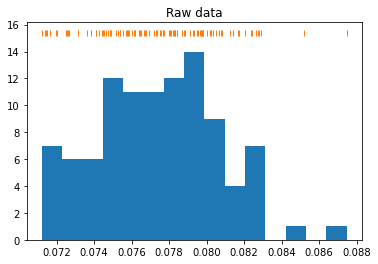

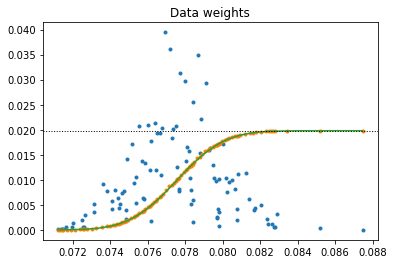

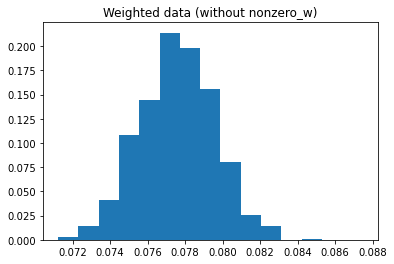

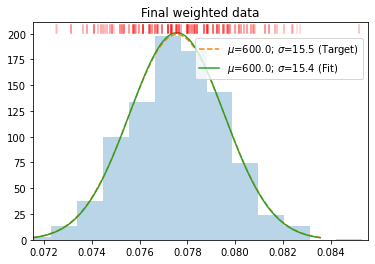

In [ ]:
wgh =  get_sample_weights(smpls_ng, T, nonzero_w=0, debug=True)

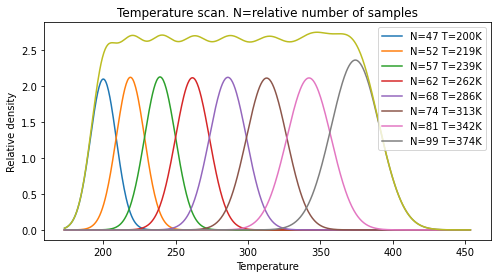

In [ ]:
# asap
N = 99
plt.figure(figsize=(8,4))
plan = plan_T_scan(200, 400, len(cryst)/3, N)
plt.savefig('T_scan_plan.pdf', bbox_inches='tight')

In [ ]:
# asap
smpll = []
for T, sig, n in track(plan, 'T scan'):
    sampler = HECSS_Sampler_TNG(cryst, asap3.OpenKIMcalculator(model),
                            T, N=int(n))
    smpll.append([s for s in sampler])
ell = [[s[-1] for s in sl] for sl in smpll]

Output()

In [ ]:
usmp = []
for sl in smpll:
    usmp += sl

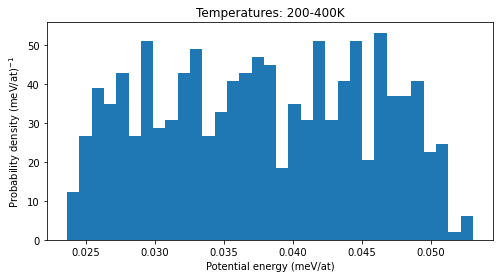

In [ ]:
plt.figure(figsize=(8,4))
plt.hist([s[-1] for s in usmp], bins=N//3, density=True)
plt.xlabel('Potential energy (meV/at)')
plt.ylabel('Probability density (meV/at)$^{-1}$')
plt.title('Temperatures: 200-400K')
plt.savefig(f'uniform.pdf', bbox_inches='tight')

(548,) (548,) 0.03437683632194917 0.0018222628179106373


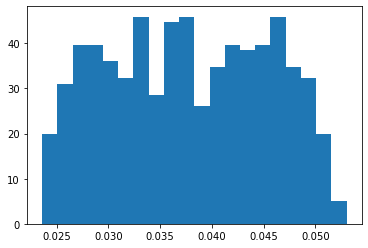

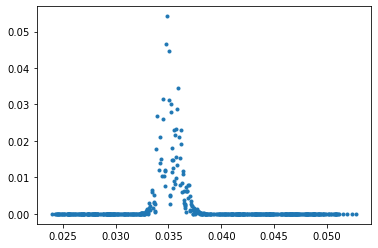

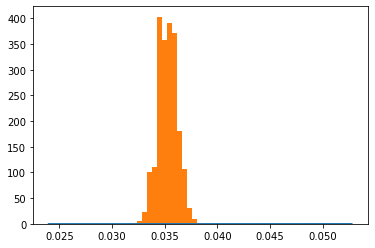

1
548 195


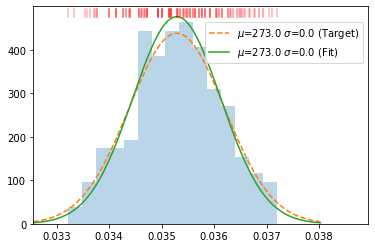

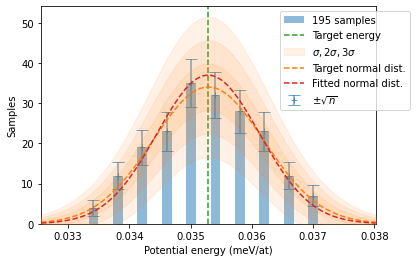

In [ ]:
T = 273
wd = make_sampling(usmp, T, N=2*N, nonzero_w=False, debug=True)
print(len(usmp), len(wd))
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))
plt.show();
plot_stats(wd, T, sqrN=True, show=False)
plt.savefig(f'T_scan_{T=:.0f}K.pdf', bbox_inches='tight')

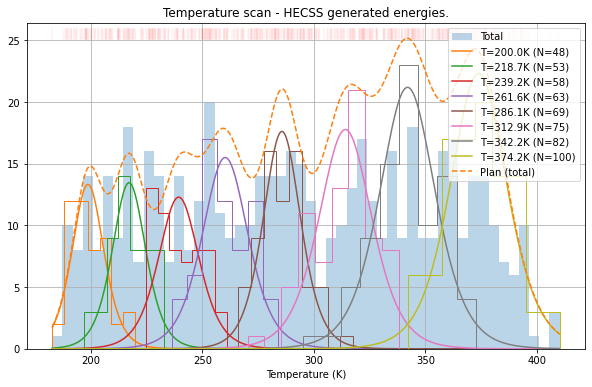

In [ ]:
# asap
plt.figure(figsize=(10,6))
if N < 1_000:
    bins = np.linspace(min(flatten(ell)), max(flatten(ell)), 40)*2/un.kB/3
else :
    bins = 'auto'
cnt, bins, _ = plt.hist(np.array(list(flatten(ell)))*2/un.kB/3, 
                     bins=50, density=False, alpha=0.3, label='Total');
x = np.linspace(bins[0], bins[-1], 300)
y = np.zeros(x.shape)
tdx = bins[1]-bins[0]
for c, (el, (T, sig, n)) in enumerate(zip(ell, plan)):
    e = np.array(el)
    bins = 'auto'
    Tc, Tb, _ = plt.hist(e*2/un.kB/3, bins=bins, density=False, 
                         histtype='step', color=f'C{c+1}');
    dx = Tb[1]-Tb[0]
    nf = np.sum(Tc)*dx
    # plt.plot(x, dx*n*stats.norm.pdf(x, loc=T, scale=sig), color=f'C{c+1}', 
    #          label=f'{T=:.1f}K (N={int(Tc.sum())})')
    # y += tdx*n*stats.norm.pdf(x, loc=T, scale=sig)
    fit = stats.logistic.fit(e*2/un.kB/3)
    plt.plot(x, nf*stats.logistic.pdf(x, *fit), color=f'C{c+1}', 
             label=f'{T=:.1f}K (N={int(Tc.sum())})')
    y += nf*stats.logistic.pdf(x, *fit)

    skip = len(el)//1000
    skip = max(1, skip)
    for v in e[::skip]*2/un.kB/3:
        plt.axvline(v, ymin=0.95, ymax=0.98, ls='-', color='r', alpha=0.05)
    
plt.plot(x, y, '--', label='Plan (total)')
plt.xlabel('Temperature (K)')
plt.legend(loc='upper right')
plt.title('Temperature scan - HECSS generated energies.')
plt.grid()
plt.savefig(f'T_scan_{N=}.pdf')

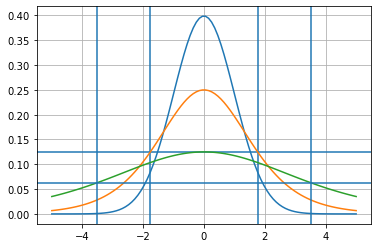

In [ ]:
x = linspace(-5, 5, 100)
plt.plot(x, stats.norm.pdf(x))
plt.grid()
plt.axhline(1/8)
plt.axvline(np.log(3+2*np.sqrt(2)))
plt.axvline(np.log(3-2*np.sqrt(2)))
plt.plot(x, stats.logistic.pdf(x))
s=2
plt.plot(x, stats.logistic.pdf(x, scale=s))
plt.axhline(1/(8*s))
plt.axvline(s*np.log(3+2*np.sqrt(2)))
plt.axvline(s*np.log(3-2*np.sqrt(2)))

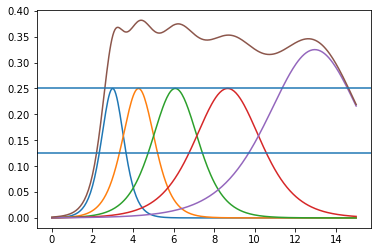

In [ ]:
x = linspace(0, 15, 300)
y = np.zeros(x.shape)
a = np.log(3+2*np.sqrt(2))
a = 1.4
x0 = 3
b = 1/8
nf = 1
while x0 < 15:
    s = x0*b
    if x0*(1+b*a)/(1-b*a) > 15:
        nf = 1.3
        x0 *= 1.05
    yy=nf*s*stats.logistic.pdf(x, loc=x0, scale=s)
    plt.plot(x,yy)
    y += yy
    x0 *= (1+a*b)/(1-a*b)
plt.plot(x,y)
plt.axhline(1/4); plt.axhline(1/8)

  0%|          | 0/6 [00:00<?, ?it/s]

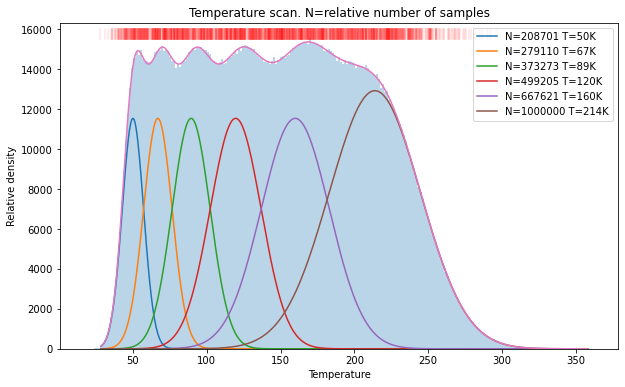

In [ ]:
# semilogx()
plt.figure(figsize=(10,6))
rv = stats.norm
N = 1_000_000
plan = plan_T_scan(50, 250, 32, N)

el = np.zeros(0)
for c, (l, s, n) in enumerate(tqdm(plan)):
    el = np.append(el, rv.rvs(loc=l, scale=s, size=n))

skip = len(el)//2000
skip = int(max(1, skip))
for s in el[::skip]:
    plt.axvline(s, ymin=0.95, ymax=0.98, ls='-', color='r', alpha=0.1)
    
NF = sum([sf for _, _, sf in plan])
counts, bins = np.histogram(el, bins='auto', density=True)
plt.hist(bins[:-1], bins, weights=NF*counts, color='C0', alpha=0.3);

## Simulate with `HECSS_Sampler` generator

In [ ]:
# asap
model = select_asap_model('SiC')
print(f'Using potential model: {model}')

sys_size = '3x3x3'
sc = [int(v) for v in sys_size.split('x')]

cryst = bulk('SiC', crystalstructure='zincblende',
                 a=4.38120844, cubic=True).repeat(tuple(sc))
cryst.set_calculator(asap3.OpenKIMcalculator(model))

Using potential model: MEAM_LAMMPS_KangEunJun_2014_SiC__MO_477506997611_000


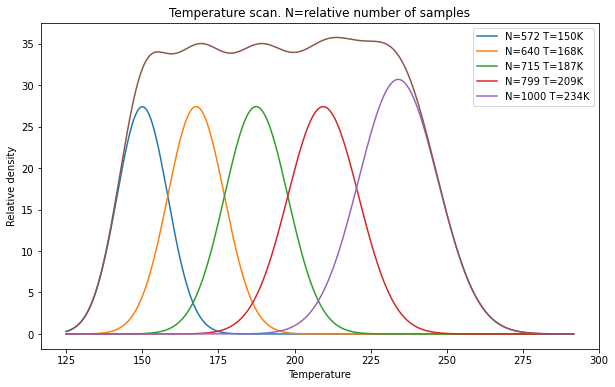

In [ ]:
# asap
N = 1_000
plt.figure(figsize=(10,6))
plan = plan_T_scan(150, 250, len(cryst), N)

In [ ]:
# asap
smpls = []
for T, sig, n in tqdm(plan):
    sampler = HECSS_Sampler(cryst, asap3.OpenKIMcalculator(model),
                            T, N=int(n), pbar=tqdm(total=n))
    smpls.append([s for s in sampler])
ell = [[s[-1] for s in sl] for sl in smpls]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/572 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/715 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

(0.015, 0.045)

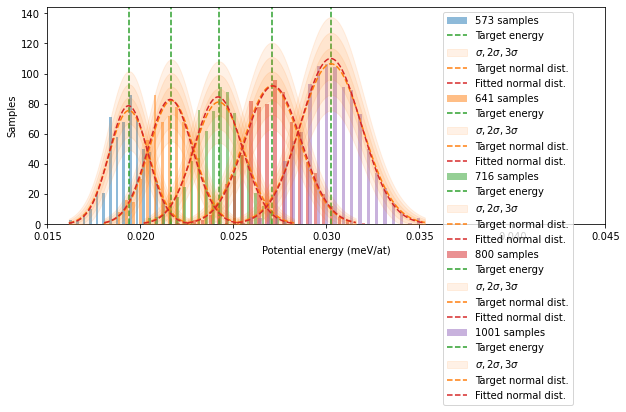

In [ ]:
# asap
plt.figure(figsize=(10,4))
for s, (T, sig, n) in zip(smpls, plan):
    plot_stats(s, T, show=False)
plt.xlim(0.015, 0.045)

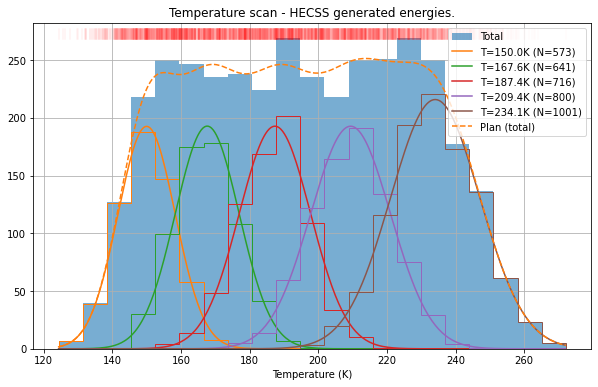

In [ ]:
# asap
plt.figure(figsize=(10,6))
if N < 1_000:
    bins = np.linspace(min(flatten(ell)), max(flatten(ell)), 40)*2/un.kB/3
else :
    bins = 'auto'
cnt, bins, _ = plt.hist(np.array(list(flatten(ell)))*2/un.kB/3, 
                     bins=bins, density=False, alpha=0.6, label='Total');
x = np.linspace(bins[0], bins[-1], 300)
y = np.zeros(x.shape)
tdx = bins[1]-bins[0]
for c, (el, (T, sig, n)) in enumerate(zip(ell, plan)):
    e = np.array(el)
    # bins = 'auto'
    Tc, Tb, _ = plt.hist(e*2/un.kB/3, bins=bins, density=False, 
                         histtype='step', color=f'C{c+1}');
    dx = Tb[1]-Tb[0]
    plt.plot(x, dx*n*stats.norm.pdf(x, loc=T, scale=sig), color=f'C{c+1}', 
             label=f'{T=:.1f}K (N={int(Tc.sum())})')
    y += tdx*n*stats.norm.pdf(x, loc=T, scale=sig)

    skip = len(el)//500
    skip = max(1, skip)
    for v in e[::skip]*2/un.kB/3:
        plt.axvline(v, ymin=0.95, ymax=0.98, ls='-', color='r', alpha=0.05)
    
plt.plot(x, y, '--', label='Plan (total)')
plt.xlabel('Temperature (K)')
plt.legend(loc='upper right')
plt.title('Temperature scan - HECSS generated energies.')
plt.grid()
plt.savefig(f'T_scan_{N=}.pdf')